# **Face Recognition Project**


---


## Part 1. Face Recognition

In [ ]:
import os
import cv2
from PIL import Image
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

sns.set(style="white")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cuda')

В самом начале рализуем Identification Rate Metric, чтобы после обучения применить данную метрику для оценки качества работы моделей

### **Задача 3. (2 балла)**
Реализовать Identification Rate Metric (ниже дан щаблон кода для него и ячейки для тестирования);

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

- *Импорт датасета для подсчета метрики*

In [ ]:
! pip3 install wldhx.yadisk-direct

In [ ]:
! yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ

https://downloader.disk.yandex.ru/disk/1b9414f6ae209570ba127039e76d8a4c8bc2b0d124baed6deac14a5bb837fc9a/668d60c4/aZ8Akc9CqtcaAMvg9MkExV6YmUo7j0uKmFHYKWBTA68gn5VRYZ8yGm8XGDKfOaeIq47moTIjJAVELBFo3-IFxA%3D%3D?uid=0&filename=celebA_ir.zip&disposition=attachment&hash=QITmbxNh1Ka87TDZIWkWnOFISuM%2BG%2BelBaYNFNjWWa9QRyNa9iZHMcwCWjNBkUwpq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=9193956&hid=fc0c59f7044b9f0444d02d8a92c6618f&media_type=compressed&tknv=v2


In [ ]:
! wget "https://downloader.disk.yandex.ru/disk/1b9414f6ae209570ba127039e76d8a4c8bc2b0d124baed6deac14a5bb837fc9a/668d60c4/aZ8Akc9CqtcaAMvg9MkExV6YmUo7j0uKmFHYKWBTA68gn5VRYZ8yGm8XGDKfOaeIq47moTIjJAVELBFo3-IFxA%3D%3D?uid=0&filename=celebA_ir.zip&disposition=attachment&hash=QITmbxNh1Ka87TDZIWkWnOFISuM%2BG%2BelBaYNFNjWWa9QRyNa9iZHMcwCWjNBkUwpq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=9193956&hid=fc0c59f7044b9f0444d02d8a92c6618f&media_type=compressed&tknv=v2" -O celebA_ir.zip
! unzip celebA_ir.zip

In [ ]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]

# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [ ]:
print(len(query_img_names))
print(len(distractors_img_names))

1222
2001


In [ ]:
def convert_to_tensor(embedding):
    if not isinstance(embedding, torch.Tensor):
        embedding = torch.FloatTensor(embedding)
    if len(embedding.shape) == 1:
        embedding = torch.unsqueeze(embedding, 0)
    return embedding

In [ ]:
def convert_to_list(cosine_similarities):
    return np.array(cosine_similarities).flatten().tolist()

In [ ]:
max_count_similarities = 1e5

In [ ]:
def compute_embeddings(model, images_list, image_type):
    """
        compute embeddings from the trained model for list of images.
        params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of images paths to compute embeddings for
        output:
        list: list of model embeddings. Each embedding corresponds to images
              names from images_list
    """
    path = "./celebA_ir/celebA_query/" if image_type == "query" else "./celebA_ir/celebA_distractors"

    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
    ])

    embeddings = []

    model.eval()
    for image_name in images_list:
        image = Image.open(os.path.join(path, image_name))
        image = torch.unsqueeze(transform(image), 0).to(device)
        with torch.no_grad():
            image_embedding = model(image)
        embeddings.append(image_embedding.detach().cpu())

    return embeddings

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    """
        compute cosine similarities between positive pairs from query (stage 1)
        params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
        output:
        list of floats: similarities between embeddings corresponding
                        to the same people from query list
    """
    image_embeddings = {image_name: image_embedding for image_name, image_embedding in zip(query_img_names, query_embeddings)}
    cosine_similarities = []

    for image_class, image_names in query_dict.items():
        for i in range(len(image_names) - 1):
            for j in range(i + 1, len(image_names)):
                embedding_1 = convert_to_tensor(image_embeddings[image_names[i]])
                embedding_2 = convert_to_tensor(image_embeddings[image_names[j]])
                cosine_similarities.append(cosine_similarity(embedding_1, embedding_2))

                if len(cosine_similarities) >= max_count_similarities:
                    return convert_to_list(cosine_similarities)

    return convert_to_list(cosine_similarities)

In [ ]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    """
        compute cosine similarities between negative pairs from query (stage 2)
        params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
        output:
        list of floats: similarities between embeddings corresponding
                        to different people from query list
    """
    image_embeddings = {image_name: image_embedding for image_name, image_embedding in zip(query_img_names, query_embeddings)}
    cosine_similarities = []

    for i, image_names_1 in enumerate(query_dict.values()):
        for j, image_names_2 in enumerate(query_dict.values()):
            if j > i:
                for name_1 in image_names_1:
                    for name_2 in image_names_2:
                        embedding_1 = convert_to_tensor(image_embeddings[name_1])
                        embedding_2 = convert_to_tensor(image_embeddings[name_2])
                        cosine_similarities.append(cosine_similarity(embedding_1, embedding_2))

                        if len(cosine_similarities) >= max_count_similarities:
                            return convert_to_list(cosine_similarities)

    return convert_to_list(cosine_similarities)

In [ ]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    """
        compute cosine similarities between negative pairs from query and distractors
        (stage 3)
        params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
        output:
        list of floats: similarities between pairs of people (q, d), where q is
                        embedding corresponding to photo from query, d —
                        embedding corresponding to photo from distractors
    """
    cosine_similarities = []

    for embedding_1 in query_embeddings:
        for embedding_2 in distractors_embeddings:
            embedding_1 = convert_to_tensor(embedding_1)
            embedding_2 = convert_to_tensor(embedding_2)
            cosine_similarities.append(cosine_similarity(embedding_1, embedding_2))

            if len(cosine_similarities) >= max_count_similarities:
                  return convert_to_list(cosine_similarities)

    return convert_to_list(cosine_similarities)

Ячейка ниже проверяет, что код работает верно:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    """
        compute identification rate using precomputer cosine similarities between pairs
        at given fpr
        params:
        cosine_query_pos: cosine similarities between positive pairs from query
        cosine_query_neg: cosine similarities between negative pairs from query
        cosine_query_distractors: cosine similarities between negative pairs
                                  from query and distractors
        fpr: false positive rate at which to compute TPR
        output:
        float: threshold for given fpr
        float: TPR at given FPR
    """
    cosine_query_pos = torch.FloatTensor(cosine_query_pos)
    cosine_query_neg = torch.FloatTensor(cosine_query_neg)
    cosine_query_distractors = torch.FloatTensor(cosine_query_distractors)

    false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
    N = round(fpr * len(false_pairs))
    false_pairs = torch.sort(false_pairs, descending=True)[0]
    threshold = false_pairs[N]
    TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)

    return threshold.item(), TPR


И ячейки для ее проверки:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

### **Задача 1. (2 балла, обязательная часть!)**
 Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации (>0.7).

- *Импорт неполного датасета для обучения 3-ей части пайплайна*

In [ ]:
! yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw

https://downloader.disk.yandex.ru/disk/a9f6c43dce81d824851fe802c6524c9d5292f170424f2cadd24c2af471163cdb/668ef1fe/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg%3D%3D?uid=0&filename=celebA_train_500.zip&disposition=attachment&hash=PKVHlR%2B3q03Ys8aOKp5s/dgbI1MoVhGrKn/oCUbHWox44FxZCGQEdyLSePCIwi7Tq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2


In [ ]:
! wget "https://downloader.disk.yandex.ru/disk/a9f6c43dce81d824851fe802c6524c9d5292f170424f2cadd24c2af471163cdb/668ef1fe/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg%3D%3D?uid=0&filename=celebA_train_500.zip&disposition=attachment&hash=PKVHlR%2B3q03Ys8aOKp5s/dgbI1MoVhGrKn/oCUbHWox44FxZCGQEdyLSePCIwi7Tq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2" -O celebA.zip
! unzip celebA.zip

- *Просмотр структуры импортированных данных*

In [ ]:
! ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


In [ ]:
images_name = os.listdir("./celebA_train_500/celebA_imgs/")
len(images_name)

23948

In [ ]:
file_annotations = open("./celebA_train_500/celebA_anno.txt", "r")
celebA_images = {}

for item in file_annotations.readlines():
    image, key = item.split()
    if key not in celebA_images:
        celebA_images[key] = []
    celebA_images[key].append(image)

file_annotations.close()

celebA_images_df = pd.DataFrame(list(celebA_images.items()), columns=["person", "images"])
celebA_images_df.set_index("person", inplace=True)
celebA_images_df["count_images"] = celebA_images_df["images"].apply(lambda images_list: len(images_list))
celebA_images_df

,images,count_images
person,,
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
495,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
496,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
497,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22


In [ ]:
print(f"Количество размеченных изображений: {celebA_images_df['count_images'].sum()}")

Количество размеченных изображений: 12011


In [ ]:
def get_paths(dataset_type="train"):
    f = open("./celebA_train_500/celebA_train_split.txt", "r")
    image_labels = f.readlines()
    f.close()

    labels = {
        "train": 0,
        "val": 1,
        "test": 2,
    }

    image_labels = [item.strip().split() for item in image_labels]
    images = [item[0] for item in image_labels if int(item[1]) == labels[dataset_type]]

    image_paths = []
    for image in images:
        image_paths.append(os.path.join("./celebA_train_500/celebA_imgs/", image))

    return image_paths

- *Предобработка данных*

In [ ]:
class celebADataset(Dataset):


    def __init__(
        self,
        dataset_type: str = "train",
        crop_images: bool = False,
        transform=None
    ):
        super().__init__()

        self.dataset_type = dataset_type
        self.crop_images = crop_images
        self.transform = transform
        self.image_paths = get_paths(self.dataset_type)

        f = open("./celebA_train_500/celebA_anno.txt", "r")
        image_labels = f.readlines()
        f.close()

        image_labels = [item.strip().split() for item in image_labels]
        image_labels = {image: int(label) for image, label in image_labels}

        self.image_labels = [int(image_labels[path.split("/")[-1]]) for path in self.image_paths]


    def __len__(self):
        return len(self.image_paths)


    def load_sample(self, file):
        image = Image.open(file)

        if self.crop_images:
            image = np.array(image)
            image = Image.fromarray(image[77:-41, 45:-50])

        return image


    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image_label = self.image_labels[index]

        image = self.load_sample(image_path)
        if self.transform:
            image = self.transform(image)

        return image, image_label

In [ ]:
augmentation = transforms.RandomChoice([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    augmentation,
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

celeba_train_dataset = celebADataset(dataset_type="train", crop_images=True, transform=train_transform)
celeba_val_dataset = celebADataset(dataset_type="val", crop_images=True, transform=test_val_transform)
celeba_test_dataset = celebADataset(dataset_type="test", crop_images=True, transform=test_val_transform)

In [ ]:
batch_size = 32

celeba_train_dataloader = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
celeba_val_dataloader = DataLoader(celeba_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
celeba_test_dataloader = DataLoader(celeba_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
from typing import Optional

def show_images(
    batch_images: torch.Tensor,
    ncols: int,
    width: int = None,
    permute_dims: tuple = (0, 2, 3, 1),
    titles: Optional[list[str]] = None
    ):
    """
      Show a batch of images
    """
    nrows = (batch_images.shape[0] // ncols) if batch_images.shape[0] % ncols == 0 else ((batch_images.shape[0] // ncols) + 1)

    if width is None:
        width = 12

    plt.figure(figsize=(width, nrows * 2))
    batch_images = batch_images.cpu().permute(permute_dims).numpy()

    for i, image in enumerate(batch_images):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image)
        plt.grid("off"); plt.axis(False)
        if titles is not None:
            plt.title(titles[i])

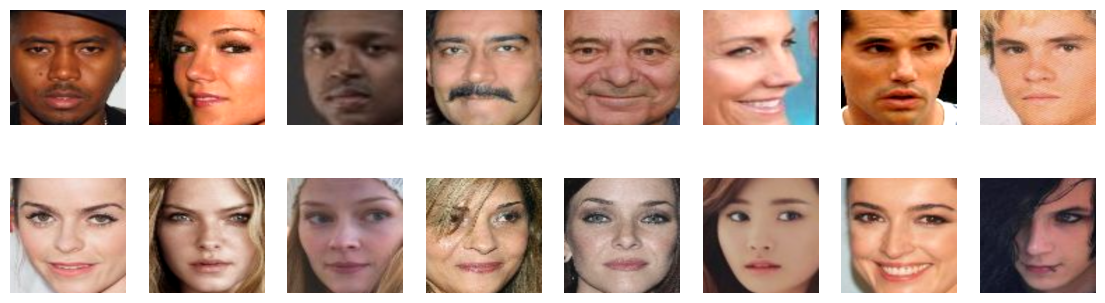

In [ ]:
images, labels = next(iter(celeba_train_dataloader))
show_images(images[:16], ncols=8, width=14)

- *Импорт предобученной модели*

Возьмем предобученную на датасете ImageNet модель ResNet34

In [ ]:
! pip install pretrainedmodels

In [ ]:
import pretrainedmodels

In [ ]:
resnet_ce = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")

In [ ]:
resnet_ce = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
resnet_ce.last_linear = nn.Linear(in_features=512, out_features=500)
resnet_ce = resnet_ce.to(device)

- *Обучим модель, используя в качестве функции ошибки перекрестную энтропию*

In [ ]:
class TrainCE:


    def __init__(
        self,
        model: nn.Module,
        n_epochs: int,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        optimizer: optim.Optimizer,
        criterion,
        scheduler,
    ):
        self.model = model
        self.n_epochs = n_epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler


    def train_epoch(self):
        self.model.train()
        current_loss = 0
        current_correct = 0
        processed_images = 0

        for images, labels in tqdm(self.train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            preds = torch.argmax(outputs, 1)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            current_loss += loss.item() * images.size(0)
            current_correct += torch.sum(preds == labels)
            processed_images += images.size(0)

        train_loss = current_loss / processed_images
        train_acc = current_correct.detach().cpu().numpy() / processed_images

        return train_loss, train_acc


    def val_epoch(self):
        self.model.eval()
        current_loss = 0
        current_correct = 0
        processed_images = 0

        for images, labels in tqdm(self.val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = self.model(images)
                preds = torch.argmax(outputs, 1)
                loss = self.criterion(outputs, labels)

            current_loss += loss.item() * images.size(0)
            current_correct += torch.sum(preds == labels)
            processed_images += images.size(0)

        val_loss = current_loss / processed_images
        val_acc = current_correct.detach().cpu().numpy() / processed_images

        return val_loss, val_acc


    def train(self):
        train_losses = []
        train_accuracy = []
        val_losses = []
        val_accuracy = []

        best_acc = 0
        best_model_weights = self.model.state_dict()

        for epoch in range(self.n_epochs):
            train_loss, train_acc = self.train_epoch()
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)

            val_loss, val_acc = self.val_epoch()
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

            print(f"Epoch {epoch + 1}/{self.n_epochs}: train loss = {train_loss}, val loss = {val_loss}, train accuracy = {train_acc}, val accuracy = {val_acc}\n")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_weights = deepcopy(self.model.state_dict())
                print("---Save new model---\n")

        return train_losses, train_accuracy, val_losses, val_accuracy, best_model_weights

In [ ]:
lr = 1e-4
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet_ce.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train_ce = TrainCE(
    model=resnet_ce,
    n_epochs=n_epochs,
    train_dataloader=celeba_train_dataloader,
    val_dataloader=celeba_val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler
)

In [ ]:
%%time
train_losses, train_accuracy, val_losses, val_accuracy, best_model_weights = train_ce.train()

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1/20: train loss = 5.80009134342608, val loss = 4.846245184239234, train accuracy = 0.04564606741573034, val accuracy = 0.15282215122470713

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2/20: train loss = 4.207824515939206, val loss = 3.6283193607045945, train accuracy = 0.2725889513108614, val accuracy = 0.3556975505857295

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3/20: train loss = 2.873981320456173, val loss = 2.7360677089427097, train accuracy = 0.5430711610486891, val accuracy = 0.5015974440894568

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4/20: train loss = 1.824797406625212, val loss = 2.1069377777548515, train accuracy = 0.7505852059925093, val accuracy = 0.6214057507987221

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 5/20: train loss = 1.057574426859952, val loss = 1.770662395844952, train accuracy = 0.8803838951310862, val accuracy = 0.6767838125665602

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 6/20: train loss = 0.5690405565254697, val loss = 1.4167055608873296, train accuracy = 0.9536516853932584, val accuracy = 0.744408945686901

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 7/20: train loss = 0.3091913471730907, val loss = 1.287766830481914, train accuracy = 0.9811563670411985, val accuracy = 0.7662406815761449

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 8/20: train loss = 0.1743480610880959, val loss = 1.2204762058326613, train accuracy = 0.9912219101123596, val accuracy = 0.7614483493077743



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 9/20: train loss = 0.11642486416501052, val loss = 1.2068745960442784, train accuracy = 0.9953183520599251, val accuracy = 0.760915867944622



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10/20: train loss = 0.08602288441404644, val loss = 1.1372348287235052, train accuracy = 0.9960205992509363, val accuracy = 0.7768903088391906

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 11/20: train loss = 0.07062672146278598, val loss = 1.0900866767595878, train accuracy = 0.9968398876404494, val accuracy = 0.7779552715654952

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12/20: train loss = 0.04889785327463784, val loss = 1.0152251406218677, train accuracy = 0.9982443820224719, val accuracy = 0.792332268370607

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 13/20: train loss = 0.03457819387553895, val loss = 1.2836787974872528, train accuracy = 0.9989466292134831, val accuracy = 0.7310969116080938



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14/20: train loss = 0.034090911568411056, val loss = 1.1249382692023207, train accuracy = 0.9985955056179775, val accuracy = 0.7699680511182109



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 15/20: train loss = 0.030733665228169064, val loss = 1.0265571125907005, train accuracy = 0.9987125468164794, val accuracy = 0.7891373801916933



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16/20: train loss = 0.025313589554489327, val loss = 0.966523526861264, train accuracy = 0.9983614232209738, val accuracy = 0.808839190628328

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 17/20: train loss = 0.0401740666855587, val loss = 1.2995756006342407, train accuracy = 0.9968398876404494, val accuracy = 0.7087326943556975



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18/20: train loss = 0.13979101564721222, val loss = 1.3755267740438542, train accuracy = 0.9845505617977528, val accuracy = 0.7002129925452609



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 19/20: train loss = 0.09272883795480827, val loss = 1.142110766630711, train accuracy = 0.9894662921348315, val accuracy = 0.7577209797657082



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 20/20: train loss = 0.03387451092520736, val loss = 1.4559994058106274, train accuracy = 0.9968398876404494, val accuracy = 0.667199148029819

CPU times: user 12min 11s, sys: 1min 4s, total: 13min 16s
Wall time: 18min 29s


In [ ]:
def plot_loss(
    train_losses: list[float],
    val_losses: list[float]
):
      """
          Show train and validation losses
      """
      fig, ax = plt.subplots(figsize=(8, 6))

      ax.plot(train_losses, label="Train losses")
      ax.plot(val_losses, label="Val losses")
      ax.set_xticks(np.arange(0, n_epochs + 1))
      ax.set_xlabel("Epoch")
      ax.set_ylabel("Loss")
      ax.legend()

      plt.show()

In [ ]:
def plot_accuracy(
    train_accuracy: list[float],
    val_accuracy: list[float]
):
      """
          Show train and validation accuracy
      """
      fig, ax = plt.subplots(figsize=(8, 6))

      ax.plot(train_accuracy, label="Train accuracy")
      ax.plot(val_accuracy, label="Val accuracy")
      ax.set_xticks(np.arange(0, n_epochs + 1))
      ax.set_xlabel("Epoch")
      ax.set_ylabel("Accuracy")
      ax.legend()

      plt.show()

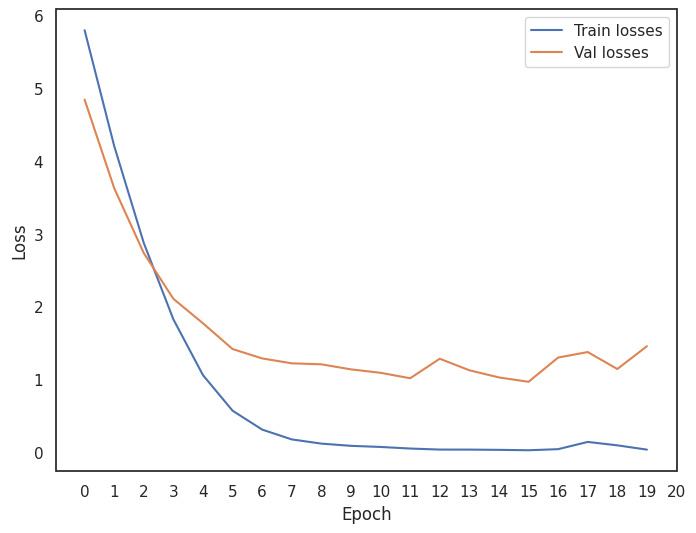

In [ ]:
plot_loss(train_losses, val_losses)

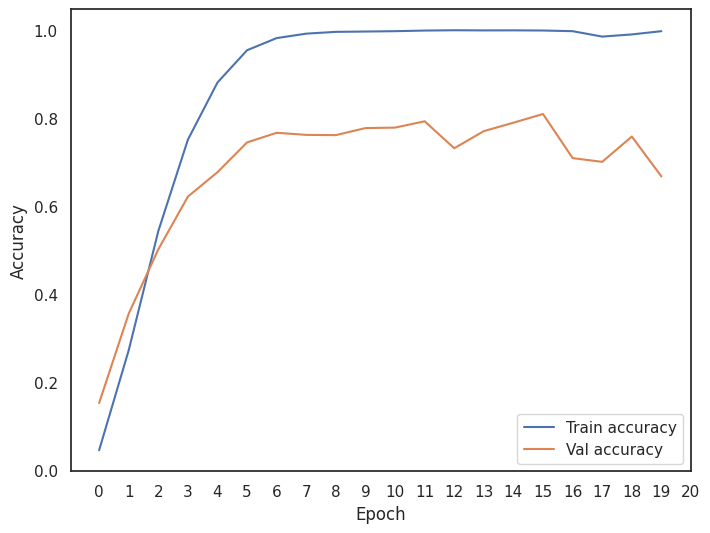

In [ ]:
plot_accuracy(train_accuracy, val_accuracy)

- *Вычислим точность на тестовых данных*

In [ ]:
def accuracy_score(model, test_dataloader):
    model.eval()
    current_correct = 0
    processed_images = 0

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            preds = torch.argmax(outputs, 1)

        current_correct += torch.sum(preds == labels)
        processed_images += images.size(0)

    test_acc = current_correct.detach().cpu().numpy() / processed_images

    return test_acc

In [ ]:
resnet_ce_best = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
resnet_ce_best.last_linear = nn.Linear(in_features=512, out_features=500)
resnet_ce_best = resnet_ce_best.to(device)
resnet_ce_best.load_state_dict(best_model_weights)

print(f"Test accuracy = {accuracy_score(resnet_ce_best, celeba_test_dataloader)}")

Test accuracy = 0.7835116425424795


- *Сохраним веса наилучшей модели*

In [ ]:
torch.save(resnet_ce_best.state_dict(), "./resnet_ce.pt")

- *Вычислим значение IR метрики*

In [ ]:
# Removing the linear layer responsible for classification
resnet_ce_best.last_linear = nn.Identity()

In [ ]:
query_embeddings = compute_embeddings(resnet_ce_best, query_img_names, "query")
distractors_embeddings = compute_embeddings(resnet_ce_best, distractors_img_names, "distractors")

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

In [ ]:
face_fpr = [0.5, 0.2, 0.1, 0.05]
face_tpr = []
for fpr in face_fpr:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    face_tpr.append(y)
    print(f"For fpr = {fpr}: TPR = {y}; Threshold similarity = {x}")

For fpr = 0.5: TPR = 0.9796888798315332; Threshold similarity = 0.51985764503479
For fpr = 0.2: TPR = 0.8902248488553767; Threshold similarity = 0.5863681435585022
For fpr = 0.1: TPR = 0.7877861558318049; Threshold similarity = 0.6264288425445557
For fpr = 0.05: TPR = 0.6638815297873786; Threshold similarity = 0.6609197854995728


In [ ]:
def plot_tpr_fpr(
    face_fpr: list[float],
    face_tpr: list[float]
):
      """
          Show True Positive Rate @ False Positive Rate
      """
      fig, ax = plt.subplots(figsize=(8, 6))

      ax.plot(face_fpr, face_tpr, marker='o')
      ax.set_xlabel("FPR")
      ax.set_ylabel("TPR")
      ax.set_title("TPR@FPR")

      plt.show()

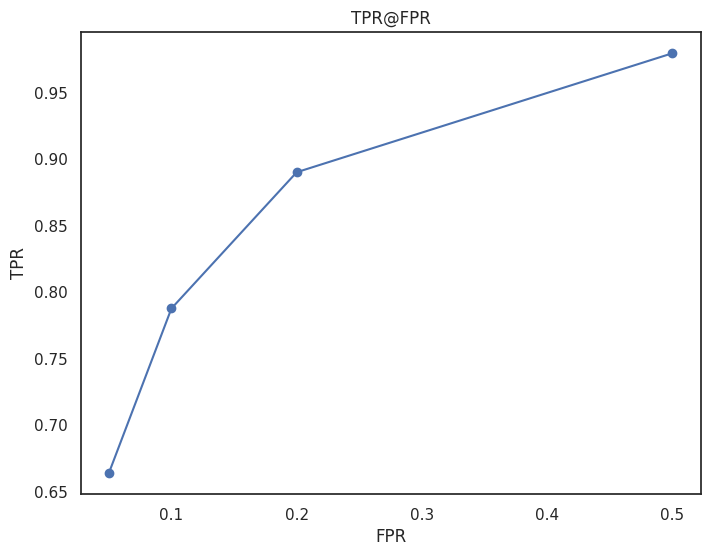

In [ ]:
plot_tpr_fpr(face_fpr, face_tpr)

### **Задача 4. (2 балла)**
Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



In [ ]:
class ResNetArcFace(nn.Module):


    def __init__(self, pretrained, requires_grad):
        super(ResNetArcFace, self).__init__()

        if pretrained == True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)

        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
        )


    def forward(self, x):
        x = self.model.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class AdditiveAngularMargin(nn.Module):


    def __init__(
        self,
        embedding_size: int,
        num_classes: int,
        m: float = 0.01,
        s: int = 9,
        easy_margin: bool = False
    ):
        super(AdditiveAngularMargin, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.m = m
        self.s = s
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size).to(device))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m


    def forward(self, input, labels):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits *= self.s

        return logits

In [ ]:
class TrainArcFace():


    def __init__(
        self,
        model: nn.Module,
        classifier: nn.Module,
        n_epochs: int,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        optimizer: optim.Optimizer,
        criterion,
        scheduler
    ):
        self.model = model
        self.classifier = classifier
        self.n_epochs = n_epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler


    def train_epoch(self):
        self.model.train()
        current_loss = 0
        current_correct = 0
        processed_images = 0

        for images, labels in tqdm(self.train_dataloader):
            images = images.to(device)
            labels = labels.to(device).long()

            self.optimizer.zero_grad()
            embeddings = self.model(images)
            outputs = self.classifier(embeddings, labels)
            preds = torch.argmax(outputs, 1)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            current_loss += loss.item() * images.size(0)
            current_correct += torch.sum(preds == labels)
            processed_images += images.size(0)

        train_loss = current_loss / processed_images
        train_acc = current_correct.detach().cpu().numpy() / processed_images

        return train_loss, train_acc


    def val_epoch(self):
        self.model.eval()
        current_loss = 0
        current_correct = 0
        processed_images = 0

        for images, labels in tqdm(self.val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                embeddings = self.model(images)
                outputs = self.classifier(embeddings, labels)
                preds = torch.argmax(outputs, 1)
                loss = self.criterion(outputs, labels)

            current_loss += loss.item() * images.size(0)
            current_correct += torch.sum(preds == labels)
            processed_images += images.size(0)

        val_loss = current_loss / processed_images
        val_acc = current_correct.detach().cpu().numpy() / processed_images

        return val_loss, val_acc


    def train(self):
        train_losses = []
        train_accuracy = []
        val_losses = []
        val_accuracy = []

        best_acc = 0
        best_model_weights = self.model.state_dict()

        for epoch in range(self.n_epochs):
            train_loss, train_acc = self.train_epoch()
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)

            val_loss, val_acc = self.val_epoch()
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

            self.scheduler.step()

            print(f"Epoch {epoch + 1}/{self.n_epochs}: train loss = {train_loss}, val loss = {val_loss}, train accuracy = {train_acc}, val accuracy = {val_acc}\n")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_weights = deepcopy(self.model.state_dict())
                print("---Save new model---\n")

        return train_losses, train_accuracy, val_losses, val_accuracy, best_model_weights

In [ ]:
resnet_arcface = ResNetArcFace(pretrained=True, requires_grad=True)
resnet_arcface = resnet_arcface.to(device)

In [ ]:
lr = 1e-4
n_epochs = 30
criterion = nn.CrossEntropyLoss()
classifier = AdditiveAngularMargin(embedding_size=512, num_classes=500)
optimizer = optim.AdamW(resnet_arcface.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train_arcface = TrainArcFace(
    model=resnet_arcface,
    classifier=classifier,
    n_epochs=n_epochs,
    train_dataloader=celeba_train_dataloader,
    val_dataloader=celeba_val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler
)

In [ ]:
%%time
train_losses, train_accuracy, val_losses, val_accuracy, best_model_weights = train_arcface.train()

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1/30: train loss = 5.708973811360334, val loss = 4.983729998778484, train accuracy = 0.07689606741573034, val accuracy = 0.23482428115015974

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2/30: train loss = 4.541847063807513, val loss = 4.181559991024046, train accuracy = 0.40625, val accuracy = 0.46166134185303515

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3/30: train loss = 3.5503805228386924, val loss = 3.4875045150232773, train accuracy = 0.6942883895131086, val accuracy = 0.6070287539936102

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4/30: train loss = 2.6563629778136923, val loss = 2.9240411622836566, train accuracy = 0.8581460674157303, val accuracy = 0.6954206602768903

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 5/30: train loss = 1.9511339262630163, val loss = 2.5679015084958303, train accuracy = 0.9400749063670412, val accuracy = 0.7470713525026624

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 6/30: train loss = 1.4113577501604173, val loss = 2.2438088058790586, train accuracy = 0.9682818352059925, val accuracy = 0.7806176783812566

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 7/30: train loss = 1.0162361893761025, val loss = 2.041209516179955, train accuracy = 0.9866573033707865, val accuracy = 0.8019169329073482

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 8/30: train loss = 0.7570030403494389, val loss = 1.8952962326419494, train accuracy = 0.9920411985018727, val accuracy = 0.8029818956336529

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 9/30: train loss = 0.587571741601501, val loss = 1.7682380956836656, train accuracy = 0.9946161048689138, val accuracy = 0.8109691160809371

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10/30: train loss = 0.4716389828853393, val loss = 1.7076664808840036, train accuracy = 0.997308052434457, val accuracy = 0.8189563365282215

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 11/30: train loss = 0.3667053118180693, val loss = 1.5051466764860386, train accuracy = 0.9985955056179775, val accuracy = 0.8359957401490948

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12/30: train loss = 0.3346442874897732, val loss = 1.470196904021457, train accuracy = 0.9992977528089888, val accuracy = 0.8434504792332268

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 13/30: train loss = 0.3164644829566113, val loss = 1.4512904340339798, train accuracy = 0.9992977528089888, val accuracy = 0.8434504792332268



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14/30: train loss = 0.3034979072626164, val loss = 1.4377227892129185, train accuracy = 0.9994147940074907, val accuracy = 0.8471778487752929

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 15/30: train loss = 0.2955200370777859, val loss = 1.425164957269947, train accuracy = 0.9997659176029963, val accuracy = 0.8471778487752929



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16/30: train loss = 0.27897404011492427, val loss = 1.4183885615092877, train accuracy = 0.9997659176029963, val accuracy = 0.8461128860489883



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 17/30: train loss = 0.2698351719629452, val loss = 1.4076935052871704, train accuracy = 0.9998829588014981, val accuracy = 0.8477103301384451

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18/30: train loss = 0.26482158910469167, val loss = 1.3902727984391843, train accuracy = 0.9996488764044944, val accuracy = 0.849307774227902

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 19/30: train loss = 0.25792473560192164, val loss = 1.3824943182821345, train accuracy = 0.9998829588014981, val accuracy = 0.8509052183173589

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 20/30: train loss = 0.24669013454226518, val loss = 1.3725596346413365, train accuracy = 0.9998829588014981, val accuracy = 0.8498402555910544



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 21/30: train loss = 0.237701136911853, val loss = 1.3662997642264199, train accuracy = 1.0, val accuracy = 0.8509052183173589



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 22/30: train loss = 0.2401297456874383, val loss = 1.3684652886959439, train accuracy = 0.9998829588014981, val accuracy = 0.8482428115015974



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 23/30: train loss = 0.23717062152950058, val loss = 1.3699125111801302, train accuracy = 1.0, val accuracy = 0.849307774227902



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 24/30: train loss = 0.23374602254410362, val loss = 1.363473093801667, train accuracy = 1.0, val accuracy = 0.8519701810436635

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 25/30: train loss = 0.23462705593207356, val loss = 1.3600204516523562, train accuracy = 1.0, val accuracy = 0.8498402555910544



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 26/30: train loss = 0.23242762389031243, val loss = 1.363882085131888, train accuracy = 1.0, val accuracy = 0.8482428115015974



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 27/30: train loss = 0.23088019014744277, val loss = 1.3612068226289191, train accuracy = 1.0, val accuracy = 0.8514376996805112



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 28/30: train loss = 0.2305566044559193, val loss = 1.3576514800897421, train accuracy = 1.0, val accuracy = 0.853035143769968

---Save new model---



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 29/30: train loss = 0.22837416944878824, val loss = 1.3550931930668946, train accuracy = 1.0, val accuracy = 0.853035143769968



  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 30/30: train loss = 0.22822930806138542, val loss = 1.35280353370439, train accuracy = 0.9998829588014981, val accuracy = 0.8509052183173589

CPU times: user 18min 40s, sys: 1min 44s, total: 20min 24s
Wall time: 30min 7s


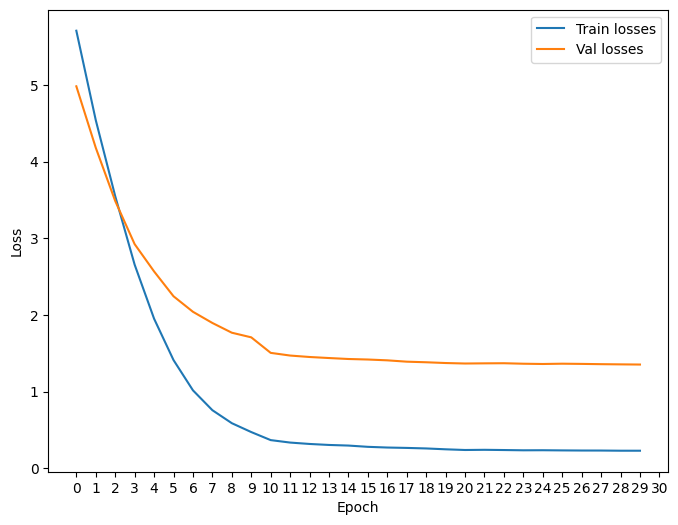

In [ ]:
plot_loss(train_losses, val_losses)

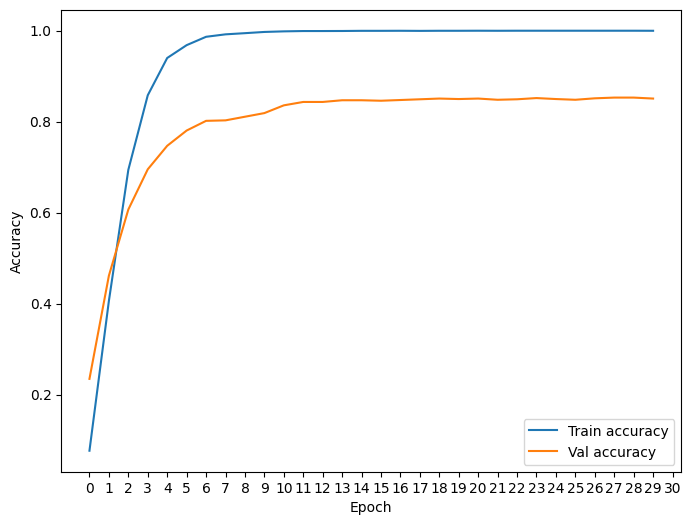

In [ ]:
plot_accuracy(train_accuracy, val_accuracy)

In [ ]:
def accuracy_score(model, classifier, test_dataloader):
    model.eval()
    current_correct = 0
    processed_images = 0

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            embeddings = model(images)
            outputs = classifier(embeddings, labels)
            preds = torch.argmax(outputs, 1)

        current_correct += torch.sum(preds == labels)
        processed_images += images.size(0)

    test_acc = current_correct.detach().cpu().numpy() / processed_images

    return test_acc

In [ ]:
resnet_arcface_best = ResNetArcFace(pretrained=True, requires_grad=True)
resnet_arcface_best = resnet_arcface_best.to(device)
resnet_arcface_best.load_state_dict(best_model_weights)

print(f"Test accuracy = {accuracy_score(resnet_arcface_best, classifier, celeba_test_dataloader)}")

Test accuracy = 0.8464443045940844


- *Сохраним веса наилучшей модели*

In [ ]:
torch.save(resnet_arcface_best.state_dict(), "./resnet_arcface.pt")

- *Вычислим значение IR метрики*

In [ ]:
query_embeddings = compute_embeddings(resnet_arcface_best, query_img_names, "query")
distractors_embeddings = compute_embeddings(resnet_arcface_best, distractors_img_names, "distractors")

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

In [ ]:
face_fpr = [0.5, 0.2, 0.1, 0.05]
face_tpr = []
for fpr in face_fpr:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    face_tpr.append(y)
    print(f"For fpr = {fpr}: TPR = {y}; Threshold similarity = {x}")

For fpr = 0.5: TPR = 0.9217444467087834; Threshold similarity = 0.020768065005540848
For fpr = 0.2: TPR = 0.8025270022416955; Threshold similarity = 0.08201244473457336
For fpr = 0.1: TPR = 0.7106174852251885; Threshold similarity = 0.11864021420478821
For fpr = 0.05: TPR = 0.6196589905577067; Threshold similarity = 0.1538129299879074


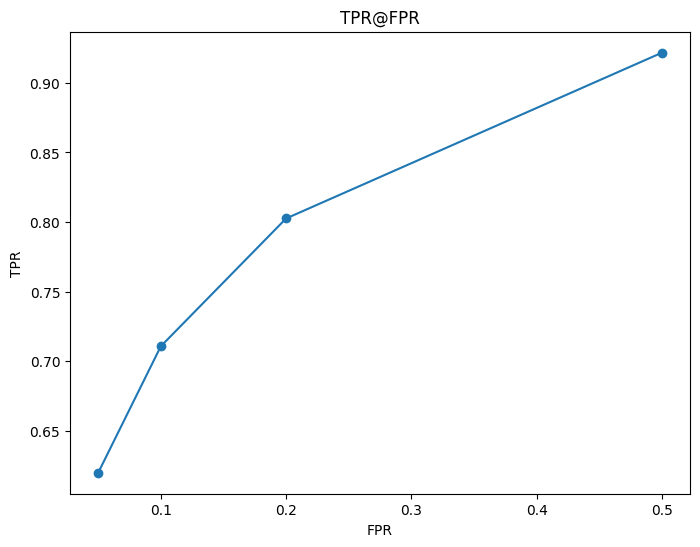

In [ ]:
plot_tpr_fpr(face_fpr, face_tpr)

### Выводы

Основными преймуществами Arcface loss являются:
- ArcFace loss вводит угловой отступ между различными классами (angular margin), что помогает лучше разделять представления классов
- Эмбенддинги изображений обученные на ArcFace loss имеют более интерпретируемое значение, т.к. они располагаются на гиперсфере (радиуса scale) и учитывают угловые расстояния, что лучше отражает структуру данных.

Модель, обученная с использованием ArcFace loss, показала более высокую точность на тестовых данных (~84,6%) по сравнению с моделью, обученной на Cross Entropy loss (~78,4%). 

Однако у модели, обученной на ArcFace loss, значения TPR при различных значениях FPR оказались чуть ниже, чем у модели, обученной на Cross Entropy loss. Это может быть связано с тем что модель, обученная на ArcFace loss, менее успешно различает лица одного человека от лиц других людей, а также с тем, что IR метрика вычислялась на ограниченном датасете, чтобы сократить время вычислений.  